# Importing Libraries

In [36]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns

# Importing Datasets

In this file, we are doing clustering between the cholera outbreak dataset and GDP dataset.

In [22]:
#Loading datasets
outbreak_file_path = '../cholera_outbreak_data/outbreak_data.csv'
gdp_file_path = '../gdp_data/gdp_data.csv'

outbreak_data = pd.read_csv(outbreak_file_path)
gdp_data = pd.read_csv(gdp_file_path)

In [23]:
#Displaying the first few rows of outbreak data
outbreak_data.head()

,location,outbreak_number,start_weekday,duration,threshold,total_suspected_cases,attack_rate,total_deaths,cfr,temporal_scale,...,pop_cat,who_region,start_date,end_date,total_confirmed_cases,spatial_scale,location_period_id,time_to_peak..weeks.,latitude,longitude
0,afr::ago::cabinda,1,Sunday,7,0.100956,61,0.062538,NaN,NaN,weekly,...,"Population <1,000,000",AFR,4/16/2017,6/3/2017,NaN,admin1,15295,5.0,-5.786515,12.211270
1,afr::ben::collines::savalou,1,Monday,16,0.278344,202,1.439298,2.0,0.990099,weekly,...,"Population <1,000,000",AFR,9/24/2012,1/13/2013,NaN,admin2,5445,4.0,7.944553,2.109204
2,afr::ben::donga::djougou,1,Monday,11,0.160480,215,0.831574,1.0,0.465116,weekly,...,"Population <1,000,000",AFR,9/10/2012,11/25/2012,NaN,admin2,1355,5.0,9.471884,1.529296
3,afr::ben::oueme::aguegues,1,Monday,6,0.515227,48,1.232645,0.0,0.000000,weekly,...,"Population <100,000",AFR,1/11/2010,2/21/2010,NaN,admin2,2959,3.0,6.428764,2.594309
4,afr::ben::oueme::bonou,1,Monday,6,0.669346,59,1.482448,2.0,3.389831,weekly,...,"Population <100,000",AFR,1/11/2010,2/21/2010,NaN,admin2,8311,3.0,6.848170,2.557924


We have proper cholera outbreak data for the year rang eof 2010 - 2022 so we will only have that data in the gdp data. 

In [24]:
gdp_data = gdp_data[["Country Name", "Country Code", "2010 [YR2010]", "2011 [YR2011]", "2012 [YR2012]", "2013 [YR2013]", 
          "2014 [YR2014]", "2015 [YR2015]", "2016 [YR2016]", "2017 [YR2017]", "2018 [YR2018]", "2019 [YR2019]", "2020 [YR2020]"]]


#Convert year columns to numeric
year_columns = gdp_data.columns[2:]
gdp_data[year_columns] = gdp_data[year_columns].apply(pd.to_numeric, errors='coerce')

# Handling Null Values: Fill null values with the mean of the respective column
for col in year_columns:
    mean_value = gdp_data[col].mean()
    gdp_data[col].fillna(mean_value, inplace=True)

#Check the first few rows after conversion
gdp_data.head()


,Country Name,Country Code,2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020]
0,Botswana,BWA,1.263727e+10,1.511064e+10,1.390746e+10,1.427174e+10,1.547009e+10,1.353075e+10,1.508264e+10,1.610516e+10,1.703194e+10,1.672591e+10,1.496029e+10
1,Burkina Faso,BFA,1.010962e+10,1.208030e+10,1.256102e+10,1.344430e+10,1.394302e+10,1.183216e+10,1.283336e+10,1.410696e+10,1.589007e+10,1.617816e+10,1.793361e+10
2,Burundi,BDI,2.032135e+09,2.235821e+09,2.333341e+09,2.451607e+09,2.705783e+09,3.104004e+09,2.644488e+09,2.723587e+09,2.667182e+09,2.576519e+09,2.649680e+09
3,Cabo Verde,CPV,1.824751e+09,2.046818e+09,1.913081e+09,2.028911e+09,2.041930e+09,1.749858e+09,1.849790e+09,1.996742e+09,2.205100e+09,2.266752e+09,1.878277e+09
4,Cameroon,CMR,2.750750e+10,3.063091e+10,3.015506e+10,3.372862e+10,3.638654e+10,3.221023e+10,3.381434e+10,3.609855e+10,3.997384e+10,3.967098e+10,4.077324e+10


The cholera data has to modified to allow for easy merging with the GDP dataset. The data has to be grouped by country, which will be each row, and then sum up the cases for each year that there is data available for.

In [25]:
#Extracting country codes and years from the data
outbreak_data['year'] = pd.to_datetime(outbreak_data['start_date']).dt.year

#Grouping data by country and year, and summing up the total suspected cases
grouped_data = outbreak_data.groupby(['country', 'year'])['total_suspected_cases'].sum().reset_index()

#Pivoting the data to have countries as rows and years as columns
pivot_data = grouped_data.pivot(index='country', columns='year', values='total_suspected_cases').reset_index()

#Filling NaN values with 0, as no cases can be interpreted as 0 cases
pivot_data.fillna(0, inplace=True)

pivot_data.head()

year,country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0
1,BEN,107.0,62.0,417.0,328.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CIV,0.0,0.0,325.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CMR,7801.0,18461.0,0.0,0.0,2052.0,7.0,0.0,0.0,966.0,464.0,0.0
4,COD,11925.0,16737.0,17693.0,13625.0,5088.0,1355.0,8518.0,33319.0,7721.0,13975.0,0.0


# Merging the Datasets

The cholera outbreak dataset uses country codes while the GDP dataset uses the name of the country so we have to find the unique countries and map the codes to the countries to merge the data.

In [26]:
#Checking unique country names in both datasets and their counts
outbreak_countries = pivot_data['country'].unique()
gdp_countries = gdp_data['Country Name'].unique()

outbreak_country_count = len(outbreak_countries)
gdp_country_count = len(gdp_countries)

outbreak_countries, outbreak_country_count, gdp_countries, gdp_country_count

(array(['AGO', 'BEN', 'CIV', 'CMR', 'COD', 'COG', 'ETH', 'GHA', 'GIN',
        'GNB', 'KEN', 'MLI', 'MOZ', 'MWI', 'NAM', 'NER', 'NGA', 'SLE',
        'SOM', 'SSD', 'TCD', 'TZA', 'TZA_zanzibar', 'UGA', 'ZMB', 'ZWE'],
       dtype=object),
 26,
 array(['Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon',
        'Central African Republic', 'Chad', 'Congo, Dem. Rep.',
        'Congo, Rep.', "Cote d'Ivoire", 'Djibouti', 'Egypt, Arab Rep.',
        'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Gabon', 'Gambia, The',
        'Ghana', 'Guinea-Bissau', 'Guinea', 'Kenya', 'Liberia', 'Libya',
        'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Namibia', 'Niger',
        'Rwanda', 'Senegal', 'Sierra Leone', 'Somalia', 'South Africa',
        'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Uganda',
        'Africa Eastern and Southern', 'Africa Western and Central',
        'Sub-Saharan Africa'], dtype=object),
 42)

In [27]:
country_code_name_mapping = {
    'AGO': 'Angola',
    'BEN': 'Benin',
    'CIV': "Cote d'Ivoire",
    'CMR': 'Cameroon',
    'COD': 'Congo, Dem. Rep.',
    'COG': 'Congo, Rep.',
    'ETH': 'Ethiopia',
    'GHA': 'Ghana',
    'GIN': 'Guinea',
    'GNB': 'Guinea-Bissau',
    'KEN': 'Kenya',
    'MLI': 'Mali',
    'MOZ': 'Mozambique',
    'MWI': 'Malawi',
    'NAM': 'Namibia',
    'NER': 'Niger',
    'NGA': 'Nigeria',
    'SLE': 'Sierra Leone',
    'SSD': 'South Sudan',
    'TCD': 'Chad',
    'TZA': 'Tanzania',
    'TZA_zanzibar': 'Zanzibar',
    'UGA': 'Uganda',
    'ZMB': 'Zambia',
    'SOM': 'Somalia',
    'ZWE': 'Zimbabwe'
}

#Mapping the country codes in the outbreak dataset to country names
pivot_data['country_name'] = pivot_data['country'].map(country_code_name_mapping)

#Merging the datasets based on the country names
merged_data = pd.merge(
    pivot_data,
    gdp_data,
    left_on='country_name',
    right_on='Country Name',
    how='inner'
)

#Displaying the first few rows of the merged dataset for verification
merged_data.head()

,country,2010,2011,2012,2013,2014,2015,2016,2017,2018,...,2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020]
0,CIV,0.0,0.0,325.0,0.0,22.0,0.0,0.0,0.0,0.0,...,3.669371e+10,3.630230e+10,4.276024e+10,4.884301e+10,4.581501e+10,4.840776e+10,5.251234e+10,5.852248e+10,5.989848e+10,6.298277e+10
1,CMR,7801.0,18461.0,0.0,0.0,2052.0,7.0,0.0,0.0,966.0,...,3.063091e+10,3.015506e+10,3.372862e+10,3.638654e+10,3.221023e+10,3.381434e+10,3.609855e+10,3.997384e+10,3.967098e+10,4.077324e+10
2,COD,11925.0,16737.0,17693.0,13625.0,5088.0,1355.0,8518.0,33319.0,7721.0,...,2.583975e+10,2.930624e+10,3.267975e+10,3.590904e+10,3.791771e+10,3.713480e+10,3.801926e+10,4.756821e+10,5.177583e+10,4.871696e+10
3,COG,0.0,0.0,283.0,439.0,0.0,0.0,0.0,0.0,0.0,...,1.565538e+10,1.769291e+10,1.795872e+10,1.791291e+10,1.189026e+10,1.021934e+10,1.109482e+10,1.367004e+10,1.275034e+10,1.048315e+10
4,GHA,1035.0,3715.0,6914.0,0.0,0.0,178.0,0.0,0.0,0.0,...,3.933667e+10,4.127171e+10,6.282463e+10,5.478332e+10,4.940601e+10,5.616493e+10,6.040592e+10,6.729891e+10,6.833797e+10,7.004310e+10


We need to add mean cholera cases overall and mean gdp for each country.

In [28]:
merged_data["Mean_Cases"] = merged_data.iloc[:, 1:11].mean(axis = 1)
merged_data["Mean_GDP"] = merged_data.iloc[:, 15:].mean(axis = 1)

In [29]:
merged_data.head()

,country,2010,2011,2012,2013,2014,2015,2016,2017,2018,...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],Mean_Cases,Mean_GDP
0,CIV,0.0,0.0,325.0,0.0,22.0,0.0,0.0,0.0,0.0,...,4.276024e+10,4.884301e+10,4.581501e+10,4.840776e+10,5.251234e+10,5.852248e+10,5.989848e+10,6.298277e+10,34.7,4.397287e+10
1,CMR,7801.0,18461.0,0.0,0.0,2052.0,7.0,0.0,0.0,966.0,...,3.372862e+10,3.638654e+10,3.221023e+10,3.381434e+10,3.609855e+10,3.997384e+10,3.967098e+10,4.077324e+10,2975.1,3.174582e+10
2,COD,11925.0,16737.0,17693.0,13625.0,5088.0,1355.0,8518.0,33319.0,7721.0,...,3.267975e+10,3.590904e+10,3.791771e+10,3.713480e+10,3.801926e+10,4.756821e+10,5.177583e+10,4.871696e+10,12995.6,3.386944e+10
3,COG,0.0,0.0,283.0,439.0,0.0,0.0,0.0,0.0,0.0,...,1.795872e+10,1.791291e+10,1.189026e+10,1.021934e+10,1.109482e+10,1.367004e+10,1.275034e+10,1.048315e+10,72.2,1.270636e+10
4,GHA,1035.0,3715.0,6914.0,0.0,0.0,178.0,0.0,0.0,0.0,...,6.282463e+10,5.478332e+10,4.940601e+10,5.616493e+10,6.040592e+10,6.729891e+10,6.833797e+10,7.004310e+10,1184.2,5.017257e+10


In [30]:
merged_data.columns = ['Country Code',
                    'cases_2010', 'cases_2011', 
                    'cases_2012', 'cases_2013', 
                    'cases_2014', 'cases_2015', 
                    'cases_2016', 'cases_2017', 
                    'cases_2018', 'cases_2019', 
                    'cases_2020', 
                    'Country Name', 'Country Name GDP', 'Country Code GDP', 
                    'gdp_2010', 'gdp_2011', 'gdp_2012', 'gdp_2013', 'gdp_2014',
                    'gdp_2015', 'gdp_2016', 'gdp_2017', 'gdp_2018', 'gdp_2019', 
                    'gdp_2020', 
                    'MeanCholeraCases', 'MeanGDP']
merged_data = merged_data[np.concatenate([["Country Name", "Country Code", "Country Name GDP", "Country Code GDP", "MeanCholeraCases", "MeanGDP"], 
                merged_data.columns[1:11], merged_data.columns[15:-2]])]
merged_data = merged_data.drop(["Country Name GDP", "Country Code GDP"], axis = 1)

In [31]:
merged_data.head()

,Country Name,Country Code,MeanCholeraCases,MeanGDP,cases_2010,cases_2011,cases_2012,cases_2013,cases_2014,cases_2015,...,gdp_2011,gdp_2012,gdp_2013,gdp_2014,gdp_2015,gdp_2016,gdp_2017,gdp_2018,gdp_2019,gdp_2020
0,Cote d'Ivoire,CIV,34.7,4.397287e+10,0.0,0.0,325.0,0.0,22.0,0.0,...,3.669371e+10,3.630230e+10,4.276024e+10,4.884301e+10,4.581501e+10,4.840776e+10,5.251234e+10,5.852248e+10,5.989848e+10,6.298277e+10
1,Cameroon,CMR,2975.1,3.174582e+10,7801.0,18461.0,0.0,0.0,2052.0,7.0,...,3.063091e+10,3.015506e+10,3.372862e+10,3.638654e+10,3.221023e+10,3.381434e+10,3.609855e+10,3.997384e+10,3.967098e+10,4.077324e+10
2,"Congo, Dem. Rep.",COD,12995.6,3.386944e+10,11925.0,16737.0,17693.0,13625.0,5088.0,1355.0,...,2.583975e+10,2.930624e+10,3.267975e+10,3.590904e+10,3.791771e+10,3.713480e+10,3.801926e+10,4.756821e+10,5.177583e+10,4.871696e+10
3,"Congo, Rep.",COG,72.2,1.270636e+10,0.0,0.0,283.0,439.0,0.0,0.0,...,1.565538e+10,1.769291e+10,1.795872e+10,1.791291e+10,1.189026e+10,1.021934e+10,1.109482e+10,1.367004e+10,1.275034e+10,1.048315e+10
4,Ghana,GHA,1184.2,5.017257e+10,1035.0,3715.0,6914.0,0.0,0.0,178.0,...,3.933667e+10,4.127171e+10,6.282463e+10,5.478332e+10,4.940601e+10,5.616493e+10,6.040592e+10,6.729891e+10,6.833797e+10,7.004310e+10


# KMeans

Using the Elbow Plot Method to find the ideal number of clusters.

/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will c

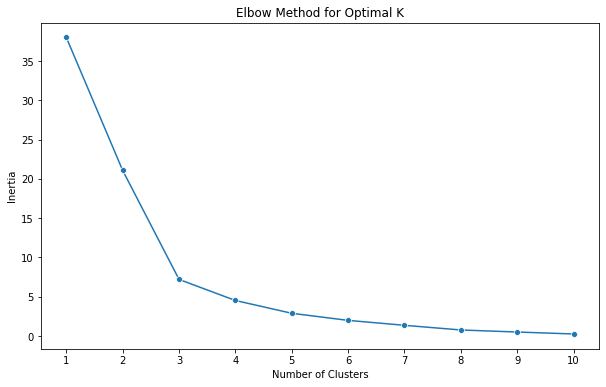

In [37]:
#Selecting relevant columns for clustering (Mean Cholera Cases and Mean GDP)
clustering_data = merged_data[['MeanCholeraCases', 'MeanGDP']]

#Standardizing the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

#Determining the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_scaled)
    inertia.append(kmeans.inertia_)

#Plotting the Elbow plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_range, y=inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

Based on the plot, k = 3. 

/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


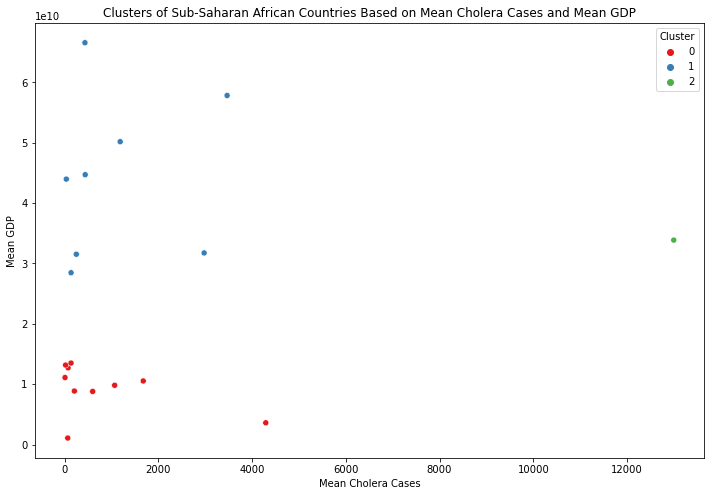

In [41]:
#Performing K-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(clustering_data_scaled)

# Adding the cluster information to the original dataframe
merged_data['Cluster'] = clusters

# Plotting the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='MeanCholeraCases', y='MeanGDP', hue='Cluster', data=merged_data, palette='Set1')
plt.title('Clusters of Sub-Saharan African Countries Based on Mean Cholera Cases and Mean GDP')
plt.xlabel('Mean Cholera Cases')
plt.ylabel('Mean GDP')
plt.legend(title='Cluster')
plt.show()